# Import necessary depencencies

In [1]:
import pandas as pd
import numpy as np
import text_normalizer as tn
import model_evaluation_utils as meu

np.set_printoptions(precision=2, linewidth=80)

# Load and normalize data

In [2]:
dataset = pd.read_csv(r'movie_reviews.csv')

# take a peek at the data
print(dataset.head())
reviews = np.array(dataset['review'])
sentiments = np.array(dataset['sentiment'])

# build train and test datasets
train_reviews = reviews[:35000]
train_sentiments = sentiments[:35000]
test_reviews = reviews[35000:]
test_sentiments = sentiments[35000:]

# normalize datasets
norm_train_reviews = tn.normalize_corpus(train_reviews)
norm_test_reviews = tn.normalize_corpus(test_reviews)

                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


# Tokenize train & test datasets

In [4]:
tokenized_train = [tn.tokenizer.tokenize(text) for text in norm_train_reviews]
tokenized_test = [tn.tokenizer.tokenize(text) for text in norm_test_reviews]

# Build Vocabulary Mapping (word to index)

In [93]:
from collections import Counter

# build word to index vocabulary
token_counter = Counter([token for review in tokenized_train for token in review])
vocab_map = {item[0]: index+1 for index, item in enumerate(dict(token_counter).items())}
max_index = np.max(list(vocab_map.values()))
vocab_map['PAD_INDEX'] = 0
vocab_map['NOT_FOUND_INDEX'] = max_index+1
vocab_size = len(vocab_map)
# view vocabulary size and part of the vocabulary map
print('Vocabulary Size:', vocab_size)
print('Sample slice of vocabulary map:', dict(list(vocab_map.items())[10:20]))

Vocabulary Size: 82358
Sample slice of vocabulary map: {'martyrdom': 6, 'palmira': 7, 'servility': 8, 'gardening': 9, 'melodramatically': 73505, 'renfro': 41282, 'carlin': 41283, 'overtly': 41284, 'rend': 47891, 'anticlimactic': 51}


# Encode and Pad datasets & Encode prediction class labels

In [94]:
from keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder

# get max length of train corpus and initialize label encoder
le = LabelEncoder()
num_classes=2 # positive -> 1, negative -> 0
max_len = np.max([len(review) for review in tokenized_train])

## Train reviews data corpus
# Convert tokenized text reviews to numeric vectors
train_X = [[vocab_map[token] for token in tokenized_review] for tokenized_review in tokenized_train]
train_X = sequence.pad_sequences(train_X, maxlen=max_len) # pad 
## Train prediction class labels
# Convert text sentiment labels (negative\positive) to binary encodings (0/1)
train_y = le.fit_transform(train_sentiments)

## Test reviews data corpus
# Convert tokenized text reviews to numeric vectors
test_X = [[vocab_map[token] if vocab_map.get(token) else vocab_map['NOT_FOUND_INDEX'] 
           for token in tokenized_review] 
              for tokenized_review in tokenized_test]
test_X = sequence.pad_sequences(test_X, maxlen=max_len)
## Test prediction class labels
# Convert text sentiment labels (negative\positive) to binary encodings (0/1)
test_y = le.transform(test_sentiments)

# view vector shapes
print('Max length of train review vectors:', max_len)
print('Train review vectors shape:', train_X.shape, ' Test review vectors shape:', test_X.shape)

Max length of train review vectors: 1442
Train review vectors shape: (35000, 1442)  Test review vectors shape: (15000, 1442)


# Build the LSTM Model Architecture

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, Dropout, SpatialDropout1D
from keras.layers import LSTM

EMBEDDING_DIM = 128 # dimension for dense embeddings for each token
LSTM_DIM = 64 # total LSTM units

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=EMBEDDING_DIM, input_length=max_len))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(LSTM_DIM, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation="sigmoid"))

model.compile(loss="binary_crossentropy", optimizer="adam",
              metrics=["accuracy"])

In [98]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 1442, 128)         10541824  
_________________________________________________________________
spatial_dropout1d_4 (Spatial (None, 1442, 128)         0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 10,591,297
Trainable params: 10,591,297
Non-trainable params: 0
_________________________________________________________________
None


# Visualize model architecture

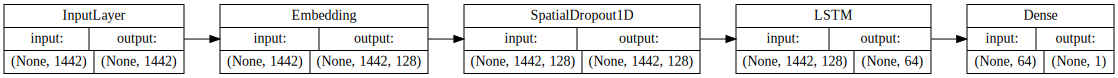

In [97]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True, show_layer_names=False, 
                 rankdir='LR').create(prog='dot', format='svg'))

# Train the model

In [74]:
batch_size = 100
model.fit(train_X, train_y, epochs=5, batch_size=batch_size, 
          shuffle=True, validation_split=0.1, verbose=1)

Train on 31500 samples, validate on 3500 samples
Epoch 1/5
31500/31500 [==============================] - 2491s - loss: 0.4081 - acc: 0.8184 - val_loss: 0.3006 - val_acc: 0.8751
Epoch 2/5
31500/31500 [==============================] - 2489s - loss: 0.2253 - acc: 0.9158 - val_loss: 0.3209 - val_acc: 0.8780
Epoch 3/5
31500/31500 [==============================] - 2656s - loss: 0.1431 - acc: 0.9493 - val_loss: 0.3483 - val_acc: 0.8671
Epoch 4/5
31500/31500 [==============================] - 2604s - loss: 0.1023 - acc: 0.9658 - val_loss: 0.3803 - val_acc: 0.8729
Epoch 5/5
31500/31500 [==============================] - 2701s - loss: 0.0694 - acc: 0.9761 - val_loss: 0.4430 - val_acc: 0.8706


# Predict and Evaluate Model Performance

In [75]:
pred_test = model.predict_classes(test_X)
predictions = le.inverse_transform(pred_test.flatten())

15000/15000 [==============================] - 352s   


In [81]:
meu.display_model_performance_metrics(true_labels=test_sentiments, predicted_labels=predictions, 
                                      classes=['positive', 'negative'])  

Model Performance metrics:
------------------------------
Accuracy: 0.88
Precision: 0.88
Recall: 0.88
F1 Score: 0.88

Model Classification report:
------------------------------
             precision    recall  f1-score   support

   positive       0.87      0.88      0.88      7510
   negative       0.88      0.87      0.88      7490

avg / total       0.88      0.88      0.88     15000


Prediction Confusion Matrix:
------------------------------
                 Predicted:         
                   positive negative
Actual: positive       6633      877
        negative        972     6518
